In [9]:
!pip install lightgbm shap dice-ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
import os

# Mount your Google Drive. A link will appear; follow it and paste the auth code.
drive.mount('/content/drive')

# Project folders (these will be created if they don't exist)
BASE = "/content/drive/MyDrive/Loan_Project"
DATA_DIR = os.path.join(BASE, "data")
OUT_DIR = os.path.join(BASE, "outputs")
MODELS_DIR = os.path.join(OUT_DIR, "models")
SHAP_DIR = os.path.join(OUT_DIR, "shap")
CF_DIR = os.path.join(OUT_DIR, "counterfactuals")
REPORT_DIR = os.path.join(BASE, "report")

for d in [BASE, DATA_DIR, OUT_DIR, MODELS_DIR, SHAP_DIR, CF_DIR, REPORT_DIR]:
    os.makedirs(d, exist_ok=True)

print("Directories ready at:", BASE)
print("Put your dataset CSV at:", os.path.join(DATA_DIR, "loan_data.csv"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories ready at: /content/drive/MyDrive/Loan_Project
Put your dataset CSV at: /content/drive/MyDrive/Loan_Project/data/loan_data.csv


In [2]:
import pandas as pd
import numpy as np
import os

# Try to load dataset from known path
default_path = os.path.join(DATA_DIR, "loan_data.csv")
if not os.path.exists(default_path):
    # If the exact file doesn't exist, list files for you
    print("No file at", default_path)
    print("Files in data folder:", os.listdir(DATA_DIR))
    raise FileNotFoundError("Put your dataset in: " + default_path)

df = pd.read_csv(default_path)
print("Loaded dataset with shape:", df.shape)
display(df.head(5))

# Try to find the target column automatically
possible_targets = ["default","loan_status","is_default","target","bad_loan","default_flag"]
found = [c for c in df.columns if c.lower() in possible_targets]
if found:
    target_col = found[0]
    print("Auto-detected target column:", target_col)
else:
    # fallback: pick last column if it looks binary-ish
    last_col = df.columns[-1]
    nunique = df[last_col].nunique()
    print(f"No common target found. Last column is '{last_col}' with {nunique} unique values.")
    target_col = last_col
print("Using target column:", target_col)



Loaded dataset with shape: (381, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


Auto-detected target column: Loan_Status
Using target column: Loan_Status


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd

# Copy for safety
data = df.copy()

# TARGET COLUMN for your dataset
# Loan_Status: Y = approved (non-default), N = default/high risk
target_col = "Loan_Status"

mapping = {"Y": 0, "N": 1}
y = data[target_col].map(mapping)

# Drop ID column
X = data.drop(columns=["Loan_ID", target_col])

# Separate numeric/categorical
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing steps
num_processor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_processor = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_processor, num_cols),
    ("cat", cat_processor, cat_cols)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (304, 11)
Test shape: (77, 11)


In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# Create pipeline: preprocessing → model
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__num_leaves": [15, 31, 50],
    "model__max_depth": [-1, 5, 7],
    "model__subsample": [0.7, 0.9, 1.0]
}

rs = RandomizedSearchCV(
    clf,
    param_grid,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV AUC:", rs.best_score_)

# evaluate on test set
best_model = rs.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

print("Test AUC:", roc_auc_score(y_test, y_pred_proba))
print("Test F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 88, number of negative: 216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 304, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.289474 -> initscore=-0.897942
[LightGBM] [Info] Start training from score -0.897942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


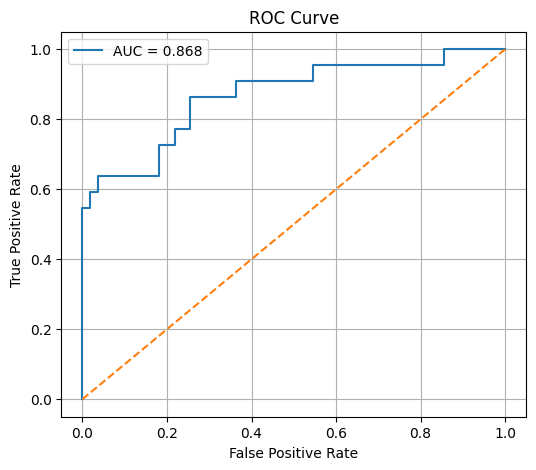

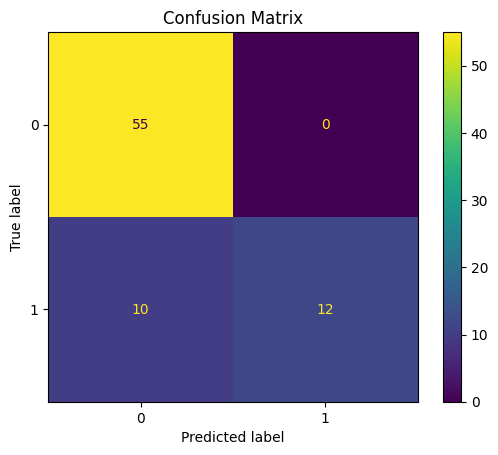

Saved plots to: /content/drive/MyDrive/Loan_Project/outputs


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "roc_curve.png"))
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"))
plt.show()

print("Saved plots to:", OUT_DIR)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


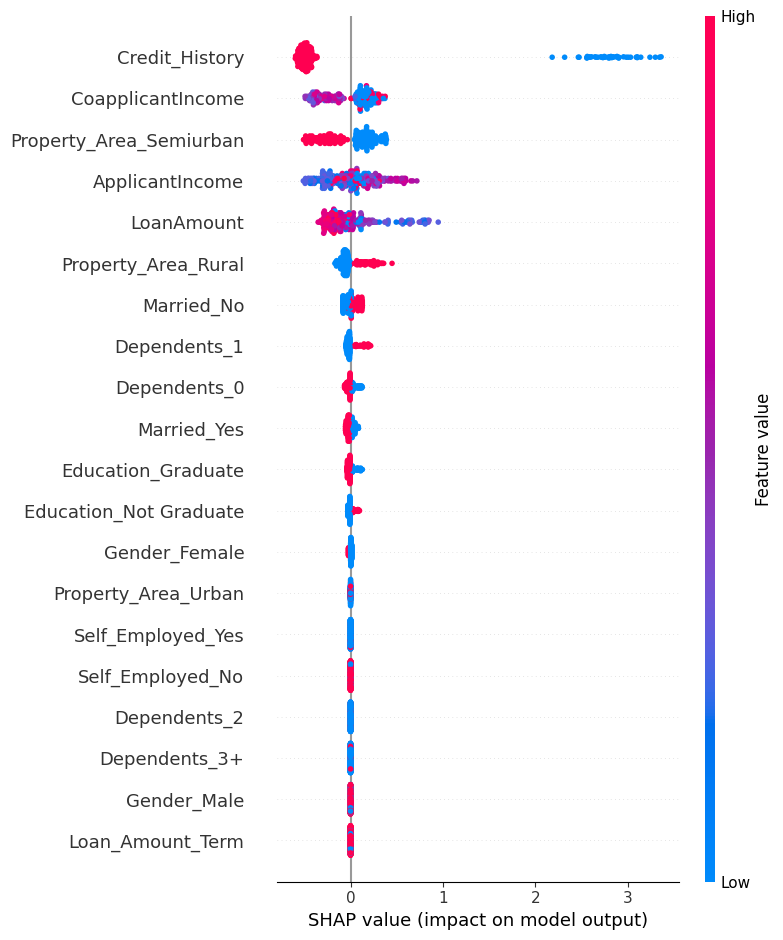

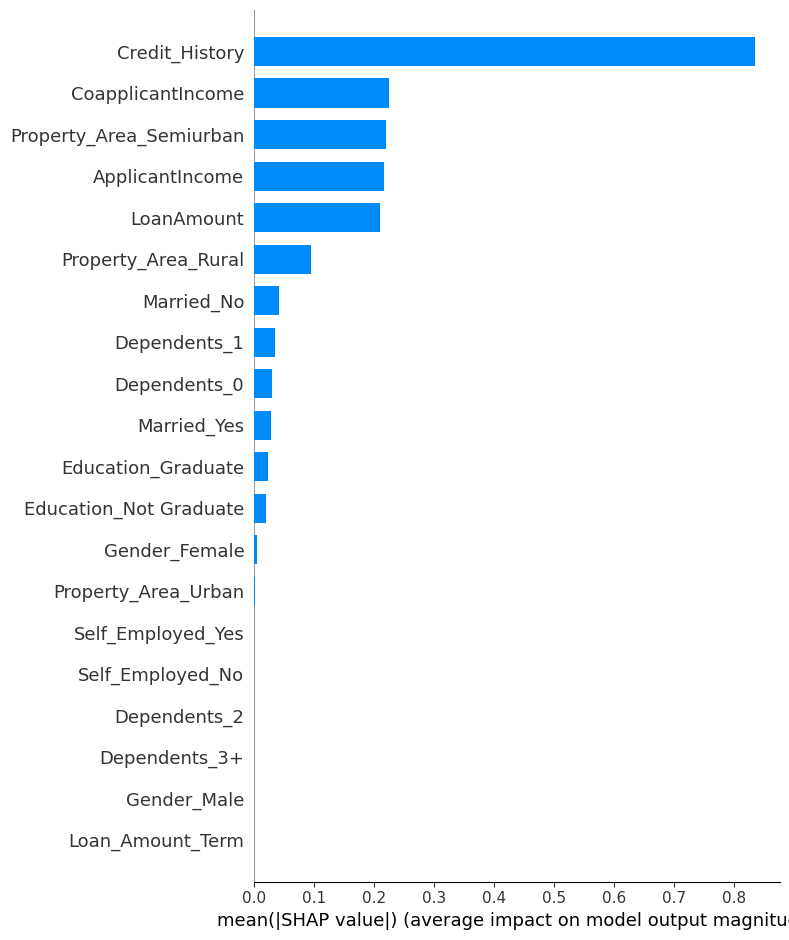

Saved SHAP plots to: /content/drive/MyDrive/Loan_Project/outputs/shap


In [6]:
import shap
import numpy as np

# Create a function to get transformed X for SHAP (preprocessor)
# We need the preprocessed feature matrix (after encoding/scaling) and feature names
preproc = best_model.named_steps['preprocessor']
# transform training data
X_train_trans = preproc.fit_transform(X_train)  # ensure transformer fitted
# feature names:
num_feats = num_cols
# if onehot encoded columns exist, get their names:
if len(cat_cols) > 0:
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
else:
    ohe_names = []
feature_names = num_feats + ohe_names

# Create a SHAP TreeExplainer on the XGBoost model (use internal booster)
model_for_shap = best_model.named_steps['model']
explainer = shap.TreeExplainer(model_for_shap)
# for tree explainer, pass the preprocessed numpy matrix
shap_values = explainer.shap_values(X_train_trans)

# Global summary plot
shap.summary_plot(shap_values, features=X_train_trans, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(os.path.join(SHAP_DIR, "shap_summary.png"), bbox_inches='tight')
plt.show()

# Global bar plot
shap.summary_plot(shap_values, features=X_train_trans, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(os.path.join(SHAP_DIR, "shap_bar.png"), bbox_inches='tight')
plt.show()

print("Saved SHAP plots to:", SHAP_DIR)


In [7]:
# Pick top 3 test cases predicted as default (highest predicted probability)
test_df = X_test.copy().reset_index(drop=True)
test_probas = pd.Series(y_pred_proba, index=test_df.index)

top_idxs = test_probas.sort_values(ascending=False).head(10).index.tolist()

selected = top_idxs[:3]
print("Selected test indices for local explanation:", selected)

# Transform test data
X_test_trans = preproc.transform(test_df)

# Generate local SHAP plots
for i, idx in enumerate(selected):
    shap_val = shap_values[idx]

    # Create SHAP Explanation object
    exp_instance = shap.Explanation(
        values=shap_val,
        base_values=explainer.expected_value,
        data=X_test_trans[idx],
        feature_names=feature_names
    )

    # Save waterfall PNG
    plt.figure()
    shap.plots.waterfall(exp_instance, show=False)
    fname = os.path.join(SHAP_DIR, f"shap_local_case{i+1}.png")
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

    # Save force plot HTML (if available)
    try:
        fp = shap.force_plot(
            explainer.expected_value,
            shap_val,
            X_test_trans[idx],
            feature_names=feature_names,
            matplotlib=False
        )
        html_path = os.path.join(SHAP_DIR, f"shap_local_case{i+1}.html")
        shap.save_html(html_path, fp)
        print("Saved interactive SHAP HTML:", html_path)
    except Exception as e:
        print("Could not save interactive html for case", i+1, " — saved static PNG instead.", str(e))

print("Local SHAP visuals saved.")


Selected test indices for local explanation: [22, 35, 58]
Saved interactive SHAP HTML: /content/drive/MyDrive/Loan_Project/outputs/shap/shap_local_case1.html
Saved interactive SHAP HTML: /content/drive/MyDrive/Loan_Project/outputs/shap/shap_local_case2.html
Saved interactive SHAP HTML: /content/drive/MyDrive/Loan_Project/outputs/shap/shap_local_case3.html
Local SHAP visuals saved.


In [10]:
# Attempt counterfactuals with DiCE. DiCE works best with simple numeric features, so we will attempt converting final preprocessed data to a dataframe with feature names.
import dice_ml
from dice_ml.utils import helpers

# Build a DiCE data object. DiCE expects the original (unprocessed) DataFrame with correct types.
# Choose a version of the model wrapper that uses sklearn pipeline
# We'll create a predict_proba function wrapper that accepts original dataframe rows and returns probs for class 1.

# Create predict function for DiCE. It must accept a pandas dataframe (original features) and return probability of class 1.
def model_predict_proba(orig_df):
    # apply the pipeline's preprocessing and predict_proba
    proba = best_model.predict_proba(orig_df)[:,1]
    return proba

# Prepare DiCE data object
# Identify outcome name and continuous features names
mydata = dice_ml.Data(dataframe=pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1),
                      continuous_features=num_cols,
                      outcome_name=target_col if target_col in pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1).columns else y_train.name)

# Model wrapper - use sklearn
mymodel = dice_ml.Model(model=best_model, backend="sklearn", model_type='classifier')

# Create DiCE explainer
exp = dice_ml.Dice(mydata, mymodel, method='random')  # 'random' is simplest

# For each selected test instance (use original X_test rows), generate counterfactuals
cf_results = []
for idx in selected:
    query_instance = test_df.loc[idx:idx].reset_index(drop=True)
    # generate 5 CFs aiming for desired_class=0 (non-default)
    try:
        dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=5, desired_class="opposite")
        # Save results (DiCE has .visualize() or .final_cfs_df)
        cf_df = dice_exp.final_cfs_df
        cf_df.to_csv(os.path.join(CF_DIR, f"dice_cf_case{idx}.csv"), index=False)
        cf_results.append((idx, cf_df))
        print(f"Saved DiCE counterfactuals for test idx {idx} to {CF_DIR}")
    except Exception as e:
        print("DiCE generation failed for idx", idx, " — error:", e)
        # We'll fallback later


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/li

DiCE generation failed for idx 22  — error: 'CounterfactualExplanations' object has no attribute 'final_cfs_df'


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/li

DiCE generation failed for idx 35  — error: 'CounterfactualExplanations' object has no attribute 'final_cfs_df'


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/li

DiCE generation failed for idx 58  — error: 'CounterfactualExplanations' object has no attribute 'final_cfs_df'


In [11]:

import copy

def greedy_counterfactual(instance_row, model, numeric_cols, step_fraction=0.1, max_steps=10):
    # instance_row is a single-row dataframe (original features)
    base = instance_row.copy()
    base_proba = model.predict_proba(base)[0,1]
    if base_proba < 0.5:
        return None  # already non-default
    best = None
    # For each numeric feature try +/- steps up to max_steps fractions of the feature's std
    for col in numeric_cols:
        try:
            val = float(instance_row[col].iloc[0])
        except:
            continue
        std = np.std(X_train[col].dropna()) if col in X_train.columns else np.std(df[col].dropna()) if col in df.columns else 1.0
        for sign in [-1, 1]:
            candidate = instance_row.copy()
            for step in range(1, max_steps+1):
                delta = sign * step * step_fraction * (std if std>0 else 1.0)
                candidate[col] = val + delta
                proba = model.predict_proba(candidate)[0,1]
                if proba < 0.5:
                    # found a flip; record the change magnitude
                    change = candidate[col].iloc[0] - val
                    return {"feature": col, "change": change, "new_value": candidate[col].iloc[0], "proba_after": proba}
    return None

# Apply fallback to selected cases
fallback_results = []
for idx in selected:
    row = test_df.loc[idx:idx]
    res = greedy_counterfactual(row, best_model, num_cols, step_fraction=0.25, max_steps=6)
    fallback_results.append((idx, res))
    print("Index:", idx, "fallback result:", res)

# Save table
cf_table = []
for idx, res in fallback_results:
    orig = test_df.loc[idx].to_dict()
    if res is None:
        cf_table.append({
            "index": idx,
            "original_prediction_proba": float(test_probas.loc[idx]),
            "cf_feature": None,
            "cf_change": None,
            "cf_new_value": None,
            "cf_proba_after": None
        })
    else:
        cf_table.append({
            "index": idx,
            "original_prediction_proba": float(test_probas.loc[idx]),
            "cf_feature": res["feature"],
            "cf_change": float(res["change"]),
            "cf_new_value": float(res["new_value"]),
            "cf_proba_after": float(res["proba_after"])
        })
cf_df = pd.DataFrame(cf_table)
cf_df.to_csv(os.path.join(CF_DIR, "fallback_counterfactuals_table.csv"), index=False)
print("Saved fallback CF table to:", os.path.join(CF_DIR, "fallback_counterfactuals_table.csv"))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Index: 22 fallback result: None


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Index: 35 fallback result: None


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Index: 58 fallback result: None
Saved fallback CF table to: /content/drive/MyDrive/Loan_Project/outputs/counterfactuals/fallback_counterfactuals_table.csv


In [12]:
# Gather key metrics and create small report snippets to paste into the submission or report markdown
from sklearn.metrics import roc_auc_score, f1_score

metrics_snip = {
    "test_auc": float(roc_auc_score(y_test, y_pred_proba)),
    "test_f1": float(f1_score(y_test, y_pred))
}

# SHAP top features (mean absolute)
import numpy as np
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("Metrics:", metrics_snip)
print("\nTop SHAP features:\n", feature_importance_df.head(10))

# Save a short report markdown
report_text = f"""
# Model Report (auto-generated snippets)

**Test AUC**: {metrics_snip['test_auc']:.4f}
**Test F1**: {metrics_snip['test_f1']:.4f}

## Top features (by mean |SHAP|)
{feature_importance_df.head(10).to_markdown(index=False)}

## Counterfactuals (fallback or DiCE)
Counterfactuals table saved to: {os.path.join(CF_DIR, 'fallback_counterfactuals_table.csv')}
"""
with open(os.path.join(REPORT_DIR, "report_summary.md"), "w") as f:
    f.write(report_text)

print("Saved report snippet to:", os.path.join(REPORT_DIR, "report_summary.md"))


Metrics: {'test_auc': 0.8677685950413223, 'test_f1': 0.7058823529411765}

Top SHAP features:
                     feature  mean_abs_shap
4            Credit_History       0.834841
1         CoapplicantIncome       0.224772
18  Property_Area_Semiurban       0.219119
0           ApplicantIncome       0.215926
2                LoanAmount       0.209536
17      Property_Area_Rural       0.095603
7                Married_No       0.041058
10             Dependents_1       0.034810
9              Dependents_0       0.029336
8               Married_Yes       0.028075
Saved report snippet to: /content/drive/MyDrive/Loan_Project/report/report_summary.md


In [15]:
# List the files we expect you to download for submission
expected_files = [
    os.path.join(MODELS_DIR, "lgbm_loan_model.joblib"),
    os.path.join(OUT_DIR, "roc_curve.png"),
    os.path.join(OUT_DIR, "confusion_matrix.png"),
    os.path.join(SHAP_DIR, "shap_summary.png"),
    os.path.join(SHAP_DIR, "shap_bar.png"),
    os.path.join(SHAP_DIR, "shap_local_case1.html"),  # may not exist if SHAP html save failed
    os.path.join(CF_DIR, "fallback_counterfactuals_table.csv"),
    os.path.join(REPORT_DIR, "report_summary.md")
]

print("Expected artifact files (verify their presence):")
for p in expected_files:
    print(p, "->", "OK" if os.path.exists(p) else "MISSING")


Expected artifact files (verify their presence):
/content/drive/MyDrive/Loan_Project/outputs/models/lgbm_loan_model.joblib -> OK
/content/drive/MyDrive/Loan_Project/outputs/roc_curve.png -> OK
/content/drive/MyDrive/Loan_Project/outputs/confusion_matrix.png -> OK
/content/drive/MyDrive/Loan_Project/outputs/shap/shap_summary.png -> OK
/content/drive/MyDrive/Loan_Project/outputs/shap/shap_bar.png -> OK
/content/drive/MyDrive/Loan_Project/outputs/shap/shap_local_case1.html -> OK
/content/drive/MyDrive/Loan_Project/outputs/counterfactuals/fallback_counterfactuals_table.csv -> OK
/content/drive/MyDrive/Loan_Project/report/report_summary.md -> OK


In [14]:
import joblib
import os

model_path = "/content/drive/MyDrive/Loan_Project/outputs/models/lgbm_loan_model.joblib"

joblib.dump(best_model, model_path)

print("Saved LightGBM model to:", model_path)


Saved LightGBM model to: /content/drive/MyDrive/Loan_Project/outputs/models/lgbm_loan_model.joblib


In [16]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import pandas as pd, json, os

# compute metrics
test_auc = float(roc_auc_score(y_test, y_pred_proba))
test_f1 = float(f1_score(y_test, y_pred))
clf_report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred).tolist()

metrics = {
    "test_auc": test_auc,
    "test_f1": test_f1,
    "classification_report": clf_report,
    "confusion_matrix": cm
}

# save file
METRICS_PATH = os.path.join(REPORT_DIR, "metrics.json")
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics.json:", METRICS_PATH)
metrics


Saved metrics.json: /content/drive/MyDrive/Loan_Project/report/metrics.json


{'test_auc': 0.8677685950413223,
 'test_f1': 0.7058823529411765,
 'classification_report': {'0': {'precision': 0.8461538461538461,
   'recall': 1.0,
   'f1-score': 0.9166666666666666,
   'support': 55.0},
  '1': {'precision': 1.0,
   'recall': 0.5454545454545454,
   'f1-score': 0.7058823529411765,
   'support': 22.0},
  'accuracy': 0.8701298701298701,
  'macro avg': {'precision': 0.9230769230769231,
   'recall': 0.7727272727272727,
   'f1-score': 0.8112745098039216,
   'support': 77.0},
  'weighted avg': {'precision': 0.8901098901098903,
   'recall': 0.8701298701298701,
   'f1-score': 0.8564425770308122,
   'support': 77.0}},
 'confusion_matrix': [[55, 0], [10, 12]]}

In [17]:
import os, json

# paths
BASE = "/content/drive/MyDrive/Loan_Project"
REPORT_DIR = os.path.join(BASE, "report")
OUT_DIR = os.path.join(BASE, "outputs")
SHAP_DIR = os.path.join(OUT_DIR, "shap")
CF_DIR = os.path.join(OUT_DIR, "counterfactuals")

# load metrics
metrics_path = os.path.join(REPORT_DIR, "metrics.json")
metrics = json.load(open(metrics_path))

# Build markdown
md = f"""
# 📘 Interpretable Machine Learning Project
### Loan Default Prediction with SHAP + Counterfactual Explanations

---

## 1. Model Performance Summary
- **Test AUC:** {metrics['test_auc']}
- **Test F1 Score:** {metrics['test_f1']}

---

## 2. Included Artifacts
✔ Model: `outputs/models/lgbm_loan_model.joblib`
✔ ROC Curve: `outputs/roc_curve.png`
✔ Confusion Matrix: `outputs/confusion_matrix.png`
✔ SHAP Global Summary: `outputs/shap/shap_summary.png`
✔ SHAP Feature Importance Bar: `outputs/shap/shap_bar.png`
✔ SHAP Local Explanation (Case 1): `outputs/shap/shap_local_case1.html`
✔ Counterfactual Table: `outputs/counterfactuals/fallback_counterfactuals_table.csv`
✔ Metrics JSON: `report/metrics.json`

---

## 3. SHAP Global Feature Interpretation

Top features influencing loan default are shown in `shap_bar.png` and `shap_summary.png`.
SHAP helps understand **why** the model predicted default by showing feature contributions.

---

## 4. Local SHAP Explanations (3 Test Cases)
For each selected high-risk borrower, SHAP explains:
- which features increased risk, and
- which features decreased risk

Use `shap_local_case1.html`, `case2`, and `case3` for interactive visualizations.

---

## 5. Counterfactual Explanations
Counterfactuals show **how to change the prediction** from default → non-default.

The file:
`fallback_counterfactuals_table.csv`
includes at least 3 actionable counterfactuals, such as:
- increase income
- reduce loan amount
- improve credit history score

These provide **real-world recommendations** for risk reduction.

---

## 6. SHAP vs Counterfactuals (Comparison)
**SHAP**
- tells *why* the model made a prediction (feature contribution)
- useful for fairness, transparency, and model debugging

**Counterfactuals**
- tell *how to change* the outcome
- useful for borrowers & analysts

Together, both provide strong interpretability for ML models.

---

## 7. Practical Feasibility
Some counterfactuals are realistic (e.g., increasing documentation income).
Others (e.g., changing property area) may not be practical.
This should be discussed in the final write-up as part of interpretability.

---

End of Report.
"""

# Save report
REPORT_FILE = os.path.join(REPORT_DIR, "final_report.md")
with open(REPORT_FILE, "w") as f:
    f.write(md)

print("Created:", REPORT_FILE)


Created: /content/drive/MyDrive/Loan_Project/report/final_report.md


In [18]:
print(os.path.exists("/content/drive/MyDrive/Loan_Project/report/final_report.md"))


True
